In [25]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [26]:
#pip install catboost

Problem Statement: create ML model to predict the Math score

In [27]:
# read data
data=pd.read_csv('StudentsPerformance.csv')

In [28]:
# display the first 3 rows of the data
data.head(3)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93


In [29]:
# remove the spaces in the column names

data.columns=data.columns.str.replace(" ","_").str.replace("/","_")

In [30]:
#prepare X & Y

X=data.drop('math_score',axis=1)
y=data['math_score']

In [31]:
# create a column transformer to trasform columns

# Categorical column need to be converted numerical-using One hot Encoder
# then need to standadise all the numerical columns 

# first seperate the numerical and categorical features

num_features=X.select_dtypes(exclude='object').columns
cat_features=X.select_dtypes(include='object').columns

# create object for OneHotEncoder & StandardScalar
num_transformer=StandardScaler()
cat_transformer=OneHotEncoder()

# create a pipeline using Column transformer- order: first convert categorical features to numeric then apply standard scaling

preprocessing=ColumnTransformer(
    [
        ("OneHotEncoder",cat_transformer,cat_features), 
        ("StandardScaler",num_transformer,num_features),
    ]
)

In [32]:
# transform the features of X
X=preprocessing.fit_transform(X)

In [33]:
# split the data into train & test set
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [34]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((800, 19), (200, 19), (800,), (200,))

### create a evaluate function to return all metrics after model training

In [35]:
# create a Evaluate function 

def evaluate_model(true,predicted):
    r2_score_val=r2_score(true,predicted)
    mse_score=mean_squared_error(true,predicted)
    rmse_score=np.sqrt(mse_score)
    mae_score=mean_absolute_error(true,predicted)
    
    return r2_score_val,rmse_score,mae_score   

In [36]:
# cretae a dtaframe to store model performance score
model_perform=pd.DataFrame(columns=["Model","train_test","r2_score_val","rmse_score","mae_score"])   

In [37]:
# create model list in a dcictionary format 

models={
    "RandomForestRegressor":RandomForestRegressor(),
    "AdaBoostRegressor":AdaBoostRegressor(),
    "DecisionTreeRegressor":DecisionTreeRegressor(),
    "LinearRegression":LinearRegression(),
    "Ridge":Ridge(),
    "Lasso":Lasso(),
    "KNeighborsRegressor":KNeighborsRegressor()
}

for model_name, model in models.items():
    #train the model
    model.fit(x_train,y_train)
    
    #make prediction
    y_train_pred=model.predict(x_train)
    y_test_pred=model.predict(x_test)
    
    #evaluate train set prediction
    r2_score_train,rmse_score,mae_score=evaluate_model(y_train,y_train_pred)
    model_perform = pd.concat([
    model_perform,
    pd.DataFrame([{
        "Model": model_name,
        "train_test": "train",
        "r2_score_val": r2_score_train,
        "rmse_score": rmse_score,
        "mae_score": mae_score
    }])
     ], ignore_index=True)
    
    #evaluate test set prediction
    r2_score_test, rmse_score, mae_score=evaluate_model(y_test,y_test_pred)
    model_perform = pd.concat([
    model_perform,
    pd.DataFrame([{
        "Model": model_name,
        "train_test": "test",
        "r2_score_val": r2_score_test,
        "rmse_score": rmse_score,
        "mae_score": mae_score
    }])
    ], ignore_index=True)

In [38]:
# now we will see which model has best r2 score(test set)
model_perform[model_perform['train_test']=='test'].sort_values(by='r2_score_val',ascending=False)

,Model,train_test,r2_score_val,rmse_score,mae_score
7,LinearRegression,test,0.882056,5.357269,4.180313
9,Ridge,test,0.880593,5.390387,4.211101
1,RandomForestRegressor,test,0.851655,6.008167,4.667875
3,AdaBoostRegressor,test,0.844739,6.146624,4.785490
11,Lasso,test,0.825320,6.519695,5.157882
13,KNeighborsRegressor,test,0.783813,7.253041,5.621000
5,DecisionTreeRegressor,test,0.755669,7.710707,6.135000


Note:
    
    1. Ridge Regressor has got high r2_score value

    2. Linear Regressor also have almost similiar r2_score, so we will go for Linear Regressor

## Linear Regression

When we add parameter fit_intercept=True, the linear regression model will include an intercept term, also known as the y-intercept or bias term. This intercept term allows the linear regression line to have a non-zero value even when all the input features are zero. It represents the expected value of the target variable when all the input features are zero. so the regression line will not pass through (0,0).

In [39]:
lin_mod=LinearRegression(fit_intercept=True)
lin_mod.fit(x_train,y_train)
y_pred=lin_mod.predict(x_test)
accuracy=r2_score(y_test,y_pred)

print("Accuracy score of Linear Regressor model is ",accuracy*100)

Accuracy score of Linear Regressor model is  88.20558858312128


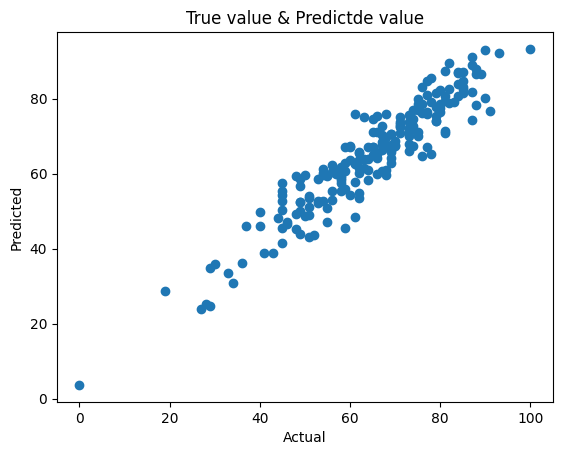

In [40]:
# plot the y_test value nad y_pred value-using matplotlib

plt.scatter(y_test,y_pred)
plt.title("True value & Predictde value")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

<Axes: xlabel='math_score'>

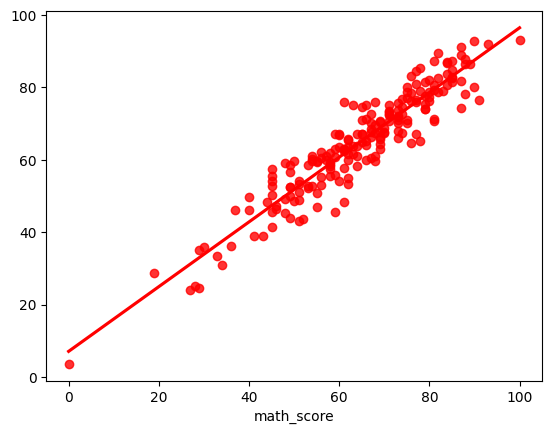

In [41]:
# using seaborn regplot
sns.regplot(x=y_test,y=y_pred,ci=None,color='r')

### Difference between Actual & predicted value

In [42]:
diff_df=pd.DataFrame({"Actual_Value":y_test,"Predicted_value":y_pred,'difference':y_test-y_pred})

diff_df

,Actual_Value,Predicted_value,difference
521,91,76.5625,14.4375
737,53,58.5000,-5.5000
740,80,77.4375,2.5625
660,74,76.9375,-2.9375
411,84,87.0625,-3.0625
...,...,...,...
408,52,43.6875,8.3125
332,62,61.5000,0.5000
208,74,67.4375,6.5625
613,65,67.1875,-2.1875
